In [1]:
# ME EN 4650  Lab5:Refrigeration    Ryan Dalby    
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matlab.engine # Must install from matlab installation direcotry using: cd "matlabroot\extern\engines\python" && python setup.py install 
from CoolProp.CoolProp import PropsSI, set_reference_state
from PIL import Image
from IPython.display import display


In [2]:
# Define useful functions
psia_to_kpa = lambda psia : psia*6.89476 # Lambda function to covert psia (absolute) to kPa (absolute)
kpa_to_pa = lambda kpa : kpa*1000 # Lambda function to convert kPa to Pa 
kpa_to_Mpa = lambda kpa : kpa/1000 # Lambda function to convert kPa to MPa 
mmHg_to_psia = lambda mmHg : mmHg*0.0193368 # Lambda function to covert mmHg to psia 
degF_to_K = lambda degF : (degF-32)*(5/9)+273.15 # Lambda function to covert degF to K
degC_to_K = lambda degC : degC+273.15 # Lambda function to covert degC to K
K_to_degC = lambda K : K-273.15 # Lambda function to covert K to degC
gpm_to_m3_s = lambda gpm : gpm/15850.32314 # Lambda function to covert gpm to m**3/s

# Set standard reference state for CoolProp for h=200 kJ/kg and s=1.0 kJ/(kg*K) for saturated liquid at T=0 degC
set_reference_state('R134a','IIR')

# Define data
T_amb = 22.8 # deg C
P_amb = 782.5-120.6 # mm Hg
W_dot_fan = 122 # fan work rate in W
psig_to_kpa_lab5 = lambda psig : psia_to_kpa(psig + mmHg_to_psia(P_amb)) # define the psig to kPa(absolute) function for this lab
eta_MH = 0.78 # Mechanical efficiency multiplied by hydraulic efficiency

flow_rate = np.array([0.2, 0.15, 0.1, 0.05]) # gpm
W_dot_total =  np.array([860, 600, 585, 480]) # Total power supplied in W 
T1 = np.array([61,68,70,70]) # deg F 
P1 = np.array([36,20,12,6]) # psig 
T2 = np.array([163,160,152,140]) # deg F 
P2 = np.array([184,159,143,131]) # psig 
T3 = np.array([86,78,75,72]) # deg F 
P3 = np.array([183,158,141,128]) # psig 
T4 = np.array([41,23,8,-6]) # deg F 
P4 = np.array([43,26,15,8]) # psig 
T5 = np.array([59,69,70,70]) # deg F 
P5 = np.array([39,24,14,8]) # psig 
Tc1 = np.array([37.7,34.8,32,29.8]) # deg c 
Tc2 = np.array([31.1,26.1,23.8,23]) # deg c 
Te1 = np.array([12.3,7.1,8.5,14.4]) # deg c 
Te2 = np.array([17.4,22.7,23.1,23]) # deg c 

# Convert quantities to desired units
flow_rate = gpm_to_m3_s(flow_rate) # m**3/s
T1 = degF_to_K(T1) # K 
P1 = psig_to_kpa_lab5(P1) # kPa 
T2 = degF_to_K(T2) # K 
P2 = psig_to_kpa_lab5(P2) # kPa 
T3 = degF_to_K(T3) # K 
P3 = psig_to_kpa_lab5(P3) # kPa 
T4 = degF_to_K(T4) # K 
P4 = psig_to_kpa_lab5(P4) # kPa 
T5 = degF_to_K(T5) # K 
P5 = psig_to_kpa_lab5(P5) # kPa 
Tc1 = degC_to_K(Tc1) # K 
Tc2 = degC_to_K(Tc2) # K 
Te1 = degC_to_K(Te1) # K 
Te2 = degC_to_K(Te2) # K 

# Calculate average air temperature at condenser and evaporator outlets
Tc_bar = 0.5*(Tc1+Tc2)
Te_bar = 0.5*(Te1+Te2)


In [3]:
# Determine enthalpy for states
h1 = PropsSI('H','T',T1,'P',kpa_to_pa(P1),'R134a')/1000 # kJ/kg
h2 = PropsSI('H','T',T2,'P',kpa_to_pa(P2),'R134a')/1000 # kJ/kg
h3 = PropsSI('H','T',T3,'P',kpa_to_pa(P3),'R134a')/1000 # kJ/kg
# Assume expansion process is adiabatic from state 3 to 4 
h4 = h3 # J/kg 
h5 = PropsSI('H','T',T5,'P',kpa_to_pa(P5),'R134a')/1000 # kJ/kg

# Determine the mass density of the refrigerant
r1 = PropsSI('D','T',T1,'P',kpa_to_pa(P1),'R134a') # kg/m**3 
r2 = PropsSI('D','T',T2,'P',kpa_to_pa(P2),'R134a') # kg/m**3 
r3 = PropsSI('D','T',T3,'P',kpa_to_pa(P3),'R134a') # kg/m**3 
r4 = PropsSI('D','T',T4,'P',kpa_to_pa(P4),'R134a') # kg/m**3 
r5 = PropsSI('D','T',T5,'P',kpa_to_pa(P5),'R134a') # kg/m**3 


In [4]:
# Calculations for COP_R
# Refrigerant mass flow rate
m_dot = r3*flow_rate # kg/s
# Electrical power 
W_dot_c = (W_dot_total - W_dot_fan)/1000 # Power of the compressor in kW
# Power supplied to refrigerant given mechanical an losses
W_dot_in = eta_MH * W_dot_c # kW
# Specific work to refrigerant
w_in = W_dot_in / m_dot # kJ/kg
# Heat rejected per unit mass from refrigerant in the condenser
q_H = -1*(h3-h2) # kJ/kg
# Heat transferred from the refrigerant per unit mass in the evaporator 
q_L = h1-h4 # kJ/kg
# Compressor energy loss per unit mass to surroundings
q_loss = w_in + h1 - h2 # kJ/kg
# COP for the refrigerator
COP_R = q_L/w_in

In [5]:
# Calculations for enthalpy at compressor exit for ideal cycle
s1 = PropsSI('S','T',T1,'P',kpa_to_pa(P1),'R134a') # J/(K*kg)
s2 = s1
h2s = PropsSI('H','T',T2,'S',s2,'R134a')/1000 # kJ/kg 
eta_c = ((h2s - h1)/(h2-h1+q_loss))*100 # In percent 


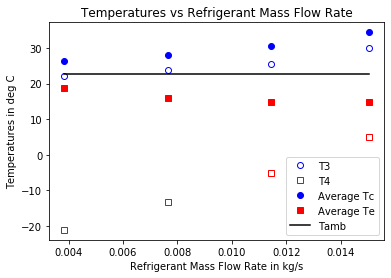

In [6]:
# 1a
plt.figure()
plt.plot(m_dot, K_to_degC(T3), 'bo', fillstyle='none')
plt.plot(m_dot, K_to_degC(T4), 'rs', fillstyle='none')
plt.plot(m_dot, K_to_degC(Tc_bar), 'bo')
plt.plot(m_dot, K_to_degC(Te_bar), 'rs')
plt.plot(m_dot, np.full(m_dot.shape,T_amb), 'k-')
plt.legend(['T3', 'T4', 'Average Tc', 'Average Te', 'Tamb'])
plt.title('Temperatures vs Refrigerant Mass Flow Rate')
plt.xlabel('Refrigerant Mass Flow Rate in kg/s')
plt.ylabel('Temperatures in deg C')
plt.show()

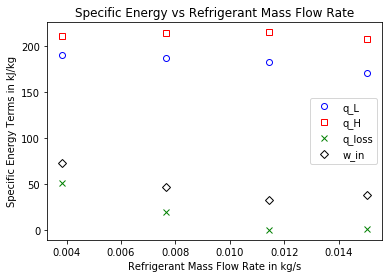

In [7]:
# 1b
plt.figure()
plt.plot(m_dot, q_L, 'bo', fillstyle='none')
plt.plot(m_dot, q_H, 'rs', fillstyle='none')
plt.plot(m_dot, q_loss, 'gx')
plt.plot(m_dot, w_in, 'kD', fillstyle='none')
plt.legend(['q_L', 'q_H', 'q_loss', 'w_in'])
plt.title('Specific Energy vs Refrigerant Mass Flow Rate')
plt.xlabel('Refrigerant Mass Flow Rate in kg/s')
plt.ylabel('Specific Energy Terms in kJ/kg')
plt.show()

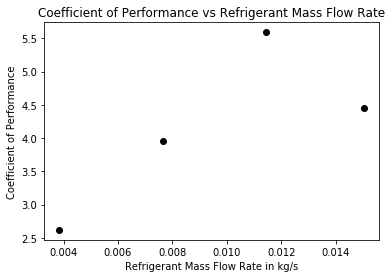

In [8]:
# 1c
plt.figure()
plt.plot(m_dot, COP_R, 'ko')
plt.title('Coefficient of Performance vs Refrigerant Mass Flow Rate')
plt.xlabel('Refrigerant Mass Flow Rate in kg/s')
plt.ylabel('Coefficient of Performance')
plt.show()


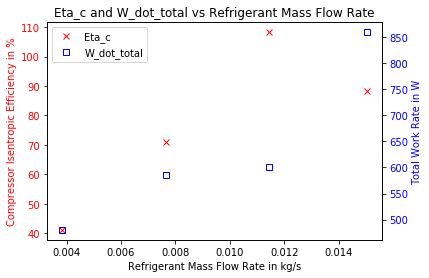

In [9]:
# 1d
fig, ax1 = plt.subplots()
lns1 = ax1.plot(m_dot, eta_c, 'rx', fillstyle='none')
ax1.set_title('Eta_c and W_dot_total vs Refrigerant Mass Flow Rate')
ax1.set_ylabel('Compressor Isentropic Efficiency in %', color='r')
ax1.set_xlabel('Refrigerant Mass Flow Rate in kg/s')
ax1.tick_params(axis='y', labelcolor='r')
ax2 = ax1.twinx()  
lns2 = ax2.plot(m_dot, W_dot_total, 'bs', fillstyle='none')
ax2.set_ylabel('Total Work Rate in W', color='b')  
ax2.tick_params(axis='y', labelcolor='b')
ax1.legend((lns1+lns2), ['Eta_c','W_dot_total'], loc=0)
plt.show()

State 1: P1 = 0.34MPa  h1 = 411.93kJ/kg
State 2: P2 = 1.36MPa  h2 = 449.15kJ/kg
State 3: P3 = 1.35MPa  h3 = 241.71kJ/kg
State 4 P4 = 0.38MPa  h4 = 241.71kJ/kg
State 5 P5 = 0.36MPa  h5 = 410.44kJ/kg


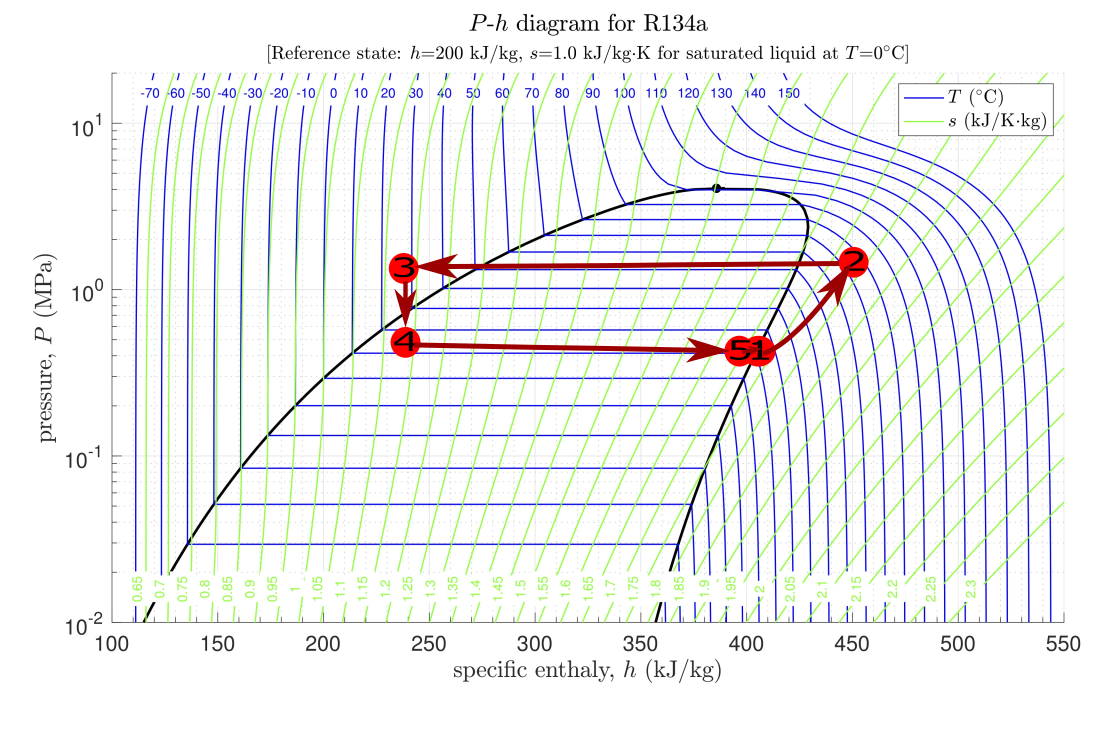

In [10]:
# 1e
# Index 0 is the highest refrigerant mass flow rate, thus will get the associated states
P1_highestmfr = kpa_to_Mpa(P1[0]) # MPa
h1_highestmfr =  h1[0] # kJ/kg 
print('State 1: P1 = {:.2f}MPa  h1 = {:.2f}kJ/kg'.format(P1_highestmfr,h1_highestmfr))
P2_highestmfr = kpa_to_Mpa(P2[0]) # MPa
h2_highestmfr =  h2[0] # kJ/kg 
print('State 2: P2 = {:.2f}MPa  h2 = {:.2f}kJ/kg'.format(P2_highestmfr,h2_highestmfr))
P3_highestmfr = kpa_to_Mpa(P3[0]) # MPa
h3_highestmfr =  h3[0] # kJ/kg 
print('State 3: P3 = {:.2f}MPa  h3 = {:.2f}kJ/kg'.format(P3_highestmfr,h3_highestmfr))
P4_highestmfr = kpa_to_Mpa(P4[0]) # MPa
h4_highestmfr =  h4[0] # kJ/kg 
print('State 4 P4 = {:.2f}MPa  h4 = {:.2f}kJ/kg'.format(P4_highestmfr,h4_highestmfr))
P5_highestmfr = kpa_to_Mpa(P5[0]) # MPa
h5_highestmfr =  h5[0] # kJ/kg 
print('State 5 P5 = {:.2f}MPa  h5 = {:.2f}kJ/kg'.format(P5_highestmfr,h5_highestmfr))

# Display image labelled in Inkscape
im = Image.open('Ph_Diagram_R134a_Labelled.png')
display(im)